I0000 00:00:1749238278.123654      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749238278.124421      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1749238278.130537      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
I0000 00:00:1749238278.925236     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


epoch 0: Train_loss=2.735093, Val_loss=2.132374, Train_acc=0.1845, Val_acc=0.3224
epoch 50: Train_loss=0.412249, Val_loss=0.872993, Train_acc=0.9238, Val_acc=0.7419
epoch 100: Train_loss=0.232829, Val_loss=0.891881, Train_acc=0.9904, Val_acc=0.7760
epoch 150: Train_loss=0.188072, Val_loss=0.910777, Train_acc=0.9970, Val_acc=0.7920
epoch 200: Train_loss=0.173238, Val_loss=0.924551, Train_acc=1.0000, Val_acc=0.7996


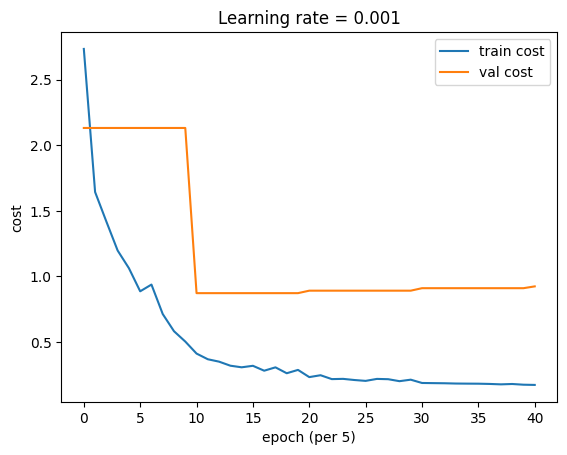

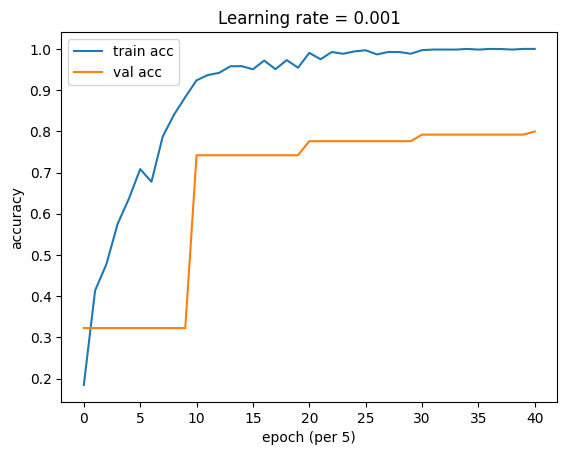

Parameters have been trained!


In [24]:
import sys
sys.path.append("/kaggle/input/fu-net/FuNET-C")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as scio 
from tf_utils import random_mini_batches_GCN1, convert_to_one_hot

# FORCE TF 1.x GRAPH/SESSION BEHAVIOR UNDER TF 2.x (DISABLE EAGER)

tf.compat.v1.disable_eager_execution()


def sample_mask(idx, l):
    
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool_)

def create_placeholders(n_x, n_x1, n_y):
   
    isTraining = tf.compat.v1.placeholder_with_default(
        True, shape=(), name="isTraining"
    )
    x_in  = tf.compat.v1.placeholder(tf.float32, [None, n_x],  name="x_in")
    x_in1 = tf.compat.v1.placeholder(tf.float32, [None, n_x1], name="x_in1")
    y_in  = tf.compat.v1.placeholder(tf.float32, [None, n_y],  name="y_in")
    lap_train = tf.compat.v1.placeholder(tf.float32, [None, None], name="lap_train")
    return x_in, x_in1, y_in, lap_train, isTraining

def initialize_parameters():
    """
    Initialize all trainable weights (using tf.compat.v1.get_variable).
    Returns a Python dict of Variables.
    """
    x_w1    = tf.compat.v1.get_variable(
        "x_w1", [200, 128], initializer=tf.compat.v1.glorot_uniform_initializer()
    )
    x_b1    = tf.compat.v1.get_variable(
        "x_b1", [128], initializer=tf.zeros_initializer()
    )

    x_jw1   = tf.compat.v1.get_variable(
        "x_jw1", [128 + 128, 128], initializer=tf.compat.v1.glorot_uniform_initializer()
    )
    x_jb1   = tf.compat.v1.get_variable(
        "x_jb1", [128], initializer=tf.zeros_initializer()
    )   
    
    x_jw2   = tf.compat.v1.get_variable(
        "x_jw2", [128, 16], initializer=tf.compat.v1.glorot_uniform_initializer()
    )
    x_jb2   = tf.compat.v1.get_variable(
        "x_jb2", [16], initializer=tf.zeros_initializer()
    )   
    
    x_conv_w1 = tf.compat.v1.get_variable(
        "x_conv_w1", [3, 3, 200, 32], initializer=tf.compat.v1.glorot_uniform_initializer()
    )
    x_conv_b1 = tf.compat.v1.get_variable(
        "x_conv_b1", [32], initializer=tf.zeros_initializer()
    )

    x_conv_w2 = tf.compat.v1.get_variable(
        "x_conv_w2", [3, 3, 32, 64], initializer=tf.compat.v1.glorot_uniform_initializer()
    )
    x_conv_b2 = tf.compat.v1.get_variable(
        "x_conv_b2", [64], initializer=tf.zeros_initializer()
    )

    x_conv_w3 = tf.compat.v1.get_variable(
        "x_conv_w3", [1, 1, 64, 128], initializer=tf.compat.v1.glorot_uniform_initializer()
    )
    x_conv_b3 = tf.compat.v1.get_variable(
        "x_conv_b3", [128], initializer=tf.zeros_initializer()
    )
    
    parameters = {
        "x_w1":      x_w1,
        "x_b1":      x_b1,
        "x_jw1":     x_jw1,
        "x_jb1":     x_jb1,
        "x_jw2":     x_jw2,
        "x_jb2":     x_jb2,
        "x_conv_w1": x_conv_w1,
        "x_conv_b1": x_conv_b1,
        "x_conv_w2": x_conv_w2,
        "x_conv_b2": x_conv_b2,
        "x_conv_w3": x_conv_w3,
        "x_conv_b3": x_conv_b3
    }
    return parameters

def GCN_layer(x_in, L_, weights):
    """
    A simple GCN operation:  x_mid = x_in·W, then x_out = L_·x_mid.
    """
    x_mid = tf.matmul(x_in, weights)
    x_out = tf.matmul(L_, x_mid)
    return x_out

def mynetwork(x, x1, parameters, Lap, isTraining, momentums=0.9):
   
    # Reshape x1 into (batch_size, 7,7,200)
    x1_reshaped = tf.reshape(x1, [-1, 7, 7, 200], name="x1_reshape")
    
    # LAYER 1 (GCN → ReLU) 
    with tf.name_scope("x_layer_1"):
        x_z1 = GCN_layer(x, Lap, parameters["x_w1"]) + parameters["x_b1"]
        x_a1 = tf.nn.relu(x_z1)

        #  Convolution branch parallel to GCN 
        # Conv → Pool → ReLU  (no BN)
        x_conv_z1 = (
            tf.nn.conv2d(
                x1_reshaped, parameters["x_conv_w1"], strides=[1,1,1,1], padding="SAME"
            ) 
            + parameters["x_conv_b1"]
        )
        x_conv_z1_po = tf.nn.max_pool2d(
            x_conv_z1,
            ksize=2,
            strides=2,
            padding="SAME",
            name="x_conv1_pool"
        )
        x_conv_a1 = tf.nn.relu(x_conv_z1_po)
                 
    # LAYER 2 (Conv2 → Pool → ReLU) 
    with tf.name_scope("x_layer_2"):   
        x_conv_z2 = (
            tf.nn.conv2d(
                x_conv_a1, parameters["x_conv_w2"], strides=[1,1,1,1], padding="SAME"
            )
            + parameters["x_conv_b2"]
        )
        x_conv_z2_po = tf.nn.max_pool2d(
            x_conv_z2,
            ksize=2,
            strides=2,
            padding="SAME",
            name="x_conv2_pool"
        )
        x_conv_a2 = tf.nn.relu(x_conv_z2_po)

    #LAYER 3 (Conv3 → Pool → ReLU) 
    with tf.name_scope("x_layer_3"):
        x_conv_z3 = (
            tf.nn.conv2d(
                x_conv_a2, parameters["x_conv_w3"], strides=[1,1,1,1], padding="SAME"
            )
            + parameters["x_conv_b3"]
        )
        x_conv_z3_po = tf.nn.max_pool2d(
            x_conv_z3,
            ksize=2,
            strides=2,
            padding="SAME",
            name="x_conv3_pool"
        )
        x_conv_a3 = tf.nn.relu(x_conv_z3_po)
        
        # Flatten conv-branch output
        x_conv_a3_shape = x_conv_a3.get_shape().as_list()
        x_conv_z3_2d = tf.reshape(
            x_conv_a3,
            [-1, x_conv_a3_shape[1] * x_conv_a3_shape[2] * x_conv_a3_shape[3]],
            name="x_conv3_flatten"
        )
        
        # Concatenate GCN branch (x_a1) and conv-branch features
        joint_encoder_layer = tf.concat(
            [x_a1, x_conv_z3_2d],
            axis=1,
            name="joint_concat"
        )

    with tf.name_scope("x_joint_layer_1"):
        x_zj1 = tf.matmul(joint_encoder_layer, parameters["x_jw1"]) + parameters["x_jb1"]
        x_aj1 = tf.nn.relu(x_zj1)

    
    with tf.name_scope("x_layer_4"):
        x_zj2 = tf.matmul(x_aj1, parameters["x_jw2"]) + parameters["x_jb2"]
    
  
    l2_loss = (
        tf.nn.l2_loss(parameters["x_w1"])    +
        tf.nn.l2_loss(parameters["x_jw1"])   +
        tf.nn.l2_loss(parameters["x_jw2"])   +
        tf.nn.l2_loss(parameters["x_conv_w1"]) +
        tf.nn.l2_loss(parameters["x_conv_w2"]) +
        tf.nn.l2_loss(parameters["x_conv_w3"])
    )
    return x_zj2, l2_loss

def mynetwork_optimization(y_est, y_re, l2_loss, reg, learning_rate, global_step):
   
    y_re = tf.squeeze(y_re, name="y_re_squeezed")
    
    with tf.name_scope("cost"):
        cost = (
            tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits=y_est, labels=y_re)
            ) 
            + reg * l2_loss
        )
    with tf.name_scope("optimization"):
        optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(cost, global_step=global_step)
    return cost, train_op

def train_mynetwork(
    x_train, x_test, train_x, test_x, y_train, y_test, L_train, L_test,
    learning_rate_base=0.001, beta_reg=0.001,
    num_epochs=200, minibatch_size=32, print_cost=True
):
    
    # Reset default graph
    tf.compat.v1.reset_default_graph()

    (m, n_x)   = x_train.shape
    (_, n_y)   = y_train.shape
    (_, n_x1)  = train_x.shape
    
    costs      = []
    costs_dev  = []
    train_acc  = []
    val_acc    = []
    

    x_in, x_in1, y_in, lap_train, isTraining = create_placeholders(n_x, n_x1, n_y)

    parameters = initialize_parameters()
    

    with tf.name_scope("network"):
        x_out, l2_loss = mynetwork(x_in, x_in1, parameters, lap_train, isTraining)

    # Exponential decay learning rate
    global_step = tf.compat.v1.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.compat.v1.train.exponential_decay(
        learning_rate_base,
        global_step,
        decay_steps=50 * m // minibatch_size,
        decay_rate=0.5,
        staircase=True,
        name="exp_decay_lr"
    )
    
    with tf.name_scope("optimization"):
        cost, optimizer = mynetwork_optimization(
            x_out, y_in, l2_loss, beta_reg, learning_rate, global_step
        )

    with tf.name_scope("metrics"):
        joint_layerT = tf.transpose(x_out)
        yT = tf.transpose(y_in)
        correct_prediction = tf.equal(
            tf.argmax(joint_layerT, axis=0),
            tf.argmax(yT, axis=0),
            name="correct_pred"
        )
        accuracy = tf.reduce_mean(
            tf.cast(correct_prediction, tf.float32),
            name="accuracy"
        )
         
    # Initialize all variables
    init = tf.compat.v1.global_variables_initializer()
    
    with tf.compat.v1.Session() as sess:
        sess.run(init)

        for epoch in range(num_epochs + 1):
            epoch_cost = 0.0
            epoch_acc  = 0.0
            num_minibatches = int(m / minibatch_size)
            seed = epoch
            minibatches = random_mini_batches_GCN1(
                x_train, train_x, y_train, L_train, minibatch_size, seed
            )

            for minibatch in minibatches:
                batch_x, batch_x1, batch_y, batch_l = minibatch
                feed_dict = {
                    x_in:       batch_x,
                    x_in1:      batch_x1,
                    y_in:       batch_y,
                    lap_train:  batch_l,
                    isTraining: True   # has no effect now that BN is removed
                }
                _, minibatch_cost, minibatch_acc = sess.run(
                    [optimizer, cost, accuracy],
                    feed_dict=feed_dict
                )
                epoch_cost += minibatch_cost / (num_minibatches + 1)
                epoch_acc  += minibatch_acc / (num_minibatches + 1)
            
            if print_cost and (epoch % 50 == 0):
                feed_dict_dev = {
                    x_in:       x_test,
                    x_in1:      test_x,
                    y_in:       y_test,
                    lap_train:  L_test,
                    isTraining: False
                }
                features_eval, epoch_cost_dev, epoch_acc_dev = sess.run(
                    [x_out, cost, accuracy],
                    feed_dict=feed_dict_dev
                )
                print(
                    f"epoch {epoch}: "
                    f"Train_loss={epoch_cost:.6f}, Val_loss={epoch_cost_dev:.6f}, "
                    f"Train_acc={epoch_acc:.4f}, Val_acc={epoch_acc_dev:.4f}"
                )
            
            if print_cost and (epoch % 5 == 0):
                costs.append(epoch_cost)
                train_acc.append(epoch_acc)
                costs_dev.append(epoch_cost_dev)
                val_acc.append(epoch_acc_dev)
      
        # Plot cost curves
        plt.plot(np.squeeze(costs), label="train cost")
        plt.plot(np.squeeze(costs_dev), label="val cost")
        plt.ylabel("cost")
        plt.xlabel("epoch (per 5)")
        plt.title("Learning rate = " + str(learning_rate_base))
        plt.legend()
        plt.show()

        # Plot accuracy curves
        plt.plot(np.squeeze(train_acc), label="train acc")
        plt.plot(np.squeeze(val_acc), label="val acc")
        plt.ylabel("accuracy")
        plt.xlabel("epoch (per 5)")
        plt.title("Learning rate = " + str(learning_rate_base))
        plt.legend()
        plt.show()
    
        trained_parameters = sess.run(parameters)
        print("Parameters have been trained!")
        return trained_parameters, val_acc, features_eval

X_train_mat = scio.loadmat('/kaggle/input/fu-net/FuNET-C/X_train.mat')
X_test_mat  = scio.loadmat('/kaggle/input/fu-net/FuNET-C/X_test.mat')
Train_X_mat = scio.loadmat('/kaggle/input/fu-net/FuNET-C/Train_X.mat')
TrLabel_mat = scio.loadmat('/kaggle/input/fu-net/FuNET-C/TrLabel.mat')
Test_X_mat  = scio.loadmat('/kaggle/input/fu-net/FuNET-C/Test_X.mat')
TeLabel_mat = scio.loadmat('/kaggle/input/fu-net/FuNET-C/TeLabel.mat')
Train_L_mat = scio.loadmat('/kaggle/input/fu-net/FuNET-C/Train_L.mat')
Test_L_mat  = scio.loadmat('/kaggle/input/fu-net/FuNET-C/Test_L.mat')


X_train = X_train_mat['X_train']   # ← THIS IS THE 7×7×200→9800 FEATUR
X_test  = X_test_mat['X_test']
Train_X = Train_X_mat['Train_X']   # ← THIS IS THE 200-dim GCN FEATURE
Test_X  = Test_X_mat['Test_X']
TrLabel = TrLabel_mat['TrLabel']
TeLabel = TeLabel_mat['TeLabel']
Train_L = Train_L_mat['Train_L']
Test_L  = Test_L_mat['Test_L']

parameters, val_acc, features = train_mynetwork(
    x_train = Train_X,   # 200-vector GCN input
    x_test  = Test_X,
    train_x = X_train,   # 9800-vector conv input
    test_x  = X_test,
    y_train = TrLabel,
    y_test  = TeLabel,
    L_train = Train_L,
    L_test  = Test_L,
    learning_rate_base=0.001,
    beta_reg=0.001,
    num_epochs=200,
    minibatch_size=32,
    print_cost=True
)

# Save the “features” extracted from the last layer into a .mat file
scio.savemat('features.mat', {'features': features})
